In [1]:
import os
import numpy as np

from configuration.configuration import Configuration #class

from pandas.core.frame import DataFrame #class
from pandas.core.series import Series #class

from datasets.aDataset import ADataset #class
from datasets.datasetML import DatasetML #class

from datasets.ml.ratings import Ratings #class
from datasets.ml.items import Items #class
from datasets.ml.users import Users #class

from history.historyDF import HistoryDF #class

from recommender.aRecommender import ARecommender #class

import pandas as pd

from sklearn.model_selection import ParameterGrid

## Prepare train and test sets

In [2]:
TRAIN_RATIO = 0.8
VALIDATION_RATIO = 0.1
dataset:DatasetML = DatasetML.readDatasets()

ratingsDF:DataFrame = dataset.ratingsDF
usersDF:DataFrame = dataset.usersDF
itemsDF:DataFrame = dataset.itemsDF

ratingsSortedDF:DataFrame = ratingsDF.sort_values(by=Ratings.COL_TIMESTAMP)
numberOfRatings:int = ratingsSortedDF.shape[0]

trainSize:int = (int)(numberOfRatings * TRAIN_RATIO)
trainRatingsDF:DataFrame = ratingsSortedDF[0:trainSize]
trainRatingsDF = trainRatingsDF.loc[trainRatingsDF[Ratings.COL_RATING] >= 4] 
#trainRatingsDF.max()

testSize:int = (int)(numberOfRatings * VALIDATION_RATIO)    
testRatingsDF:DataFrame = ratingsSortedDF[trainSize:(trainSize + testSize)]
testRatingsDF = testRatingsDF.loc[testRatingsDF[Ratings.COL_RATING] >= 4] 


testRatingsDF.reset_index(drop=True, inplace=True)
trainRatingsDF.reset_index(drop=True, inplace=True)

trainDataset:ADataset = DatasetML(trainRatingsDF, usersDF, itemsDF)
trainRatingsDF.shape

(463020, 4)

In [3]:
testRatingsDF.shape

(57808, 4)

In [4]:
testRatingsDF.head()

,userId,movieId,rating,timestamp
0,1875,1721,4,975768738
1,1875,2621,4,975768748
2,635,3095,5,975768756
3,635,36,5,975768756
4,635,608,5,975768756


## Define recommending requests + some statistics on TRUE_vals sizes

In [5]:
users = testRatingsDF[Ratings.COL_USERID].unique()
users.shape

(1103,)

In [6]:
users

array([1875,  635, 2784, ...,   26,   25,   24], dtype=int64)

In [7]:
trueList = {}
trueRelevance = {}
vals = []
maxOID = itemsDF[Items.COL_MOVIEID].max()

for user in users:
    trueValsPerUser = testRatingsDF.loc[testRatingsDF[Ratings.COL_USERID] == user]
    vals.append(trueValsPerUser.shape[0])
    #print(trueValsPerUser.shape[0])
    trueList[user] = trueValsPerUser[Ratings.COL_MOVIEID]
    relScore = np.zeros((1,maxOID+1))
    relScore[0,trueList[user].values] = 1
    trueRelevance[user] = relScore

In [8]:
trueRelevance[1875].sum()

72.0

In [9]:
import numpy as np
np.sum(vals)

57808

In [10]:
np.max(vals),np.min(vals)

(741, 1)

In [11]:
pd.Series(vals).hist()

<AxesSubplot:>

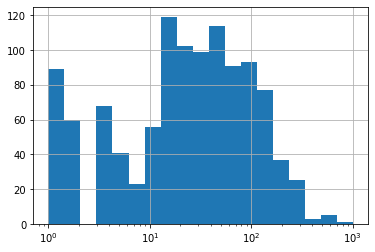

In [12]:
from matplotlib import pyplot as plt
fig, ax = plt.subplots()
pd.Series(vals).hist(ax=ax, bins=np.logspace(np.log10(1),np.log10(1000), 20))
ax.set_xscale('log')

In [13]:
trueList[1875]

0      1721
1      2621
7        11
8       539
9      1722
       ... 
133    2971
134    1220
135     938
136    1081
137    1250
Name: movieId, Length: 72, dtype: int64

In [14]:
trueList[1875].values

array([1721, 2621,   11,  539, 1722, 1088, 1101, 1597,  932, 3638, 2316,
       2942, 1409, 3206, 1381,  260, 1198,  919, 1204, 1287, 1291, 1303,
       1374, 2366, 3168, 3494, 2871, 2115, 1356, 2640, 2470, 2628,  329,
         10,  648, 2641,  674,  736, 2367, 1206, 1214, 1196, 1240,  750,
       1270, 1200,  924, 2571, 3471, 3703, 1097, 2916, 2529, 1376, 1573,
       2407, 2393, 2311, 3827,  780, 1320, 1066,  945, 2303, 3675, 3061,
       1947, 2971, 1220,  938, 1081, 1250], dtype=int64)

## Run tuning for BPRMF

In [15]:
"""param_grid = {
              'factors': [5, 10, 20, 50, 100],
              'iterations': [5, 10, 20, 50], 
              'learning_rate': [0.1, 0.03, 0.01, 0.003],
              'regularization': [0.1, 0.03, 0.01, 0.003],
             }
""" 
param_grid = {
              'factors': [5, 10, 20, 50, 100],
              'iterations': [5, 10, 20, 50], 
              'learning_rate': [0.1, 0.03, 0.01, 0.003],
              'regularization': [0.1, 0.03, 0.01, 0.003],
             }
params_list = list(ParameterGrid(param_grid)) 

In [16]:
from recommender.recommenderBPRMF import RecommenderBPRMF #class
from sklearn.metrics import ndcg_score

ModuleNotFoundError: No module named 'implicit'

In [80]:
i = 0

scoresMean = []
scoresInd = []

for params in params_list:
    i += 1
    rec:ARecommender = RecommenderBPRMF("test", params)
    rec.train(HistoryDF("hyperparams_tuning_BPRMF"+str(i)), trainDataset)
    scoresVector = []
    
    for user in users:
        recList = rec.recommend(user)
        #print(recList.index)
        #print(type(recList.index))
        #rl = np.array([i[0] for i in recList])
        #print(rl)
        relScore = np.zeros((1,maxOID+1))
        relScore[0,recList.index] = recList.values
        #print(relScore.sum())
        #print(np.isin(recList.index, trueList[user].values))
        res = ndcg_score(trueRelevance[user], relScore, k=20)
        scoresVector.append(res)
        
    meanScore = np.mean(scoresVector)
    scoresMean.append(meanScore)
    scoresInd.append(scoresVector)    

par = [params_list[0]]

resultsDF = pd.DataFrame({"params":params_list, "meanNDCG":scoresMean})
resultsDF
        
    

,params,meanNDCG
0,"{'factors': 5, 'iterations': 5, 'learning_rate...",0.231033
1,"{'factors': 5, 'iterations': 5, 'learning_rate...",0.225477
2,"{'factors': 5, 'iterations': 5, 'learning_rate...",0.227545
3,"{'factors': 5, 'iterations': 5, 'learning_rate...",0.227705
4,"{'factors': 5, 'iterations': 5, 'learning_rate...",0.223632
...,...,...
315,"{'factors': 100, 'iterations': 50, 'learning_r...",0.222730
316,"{'factors': 100, 'iterations': 50, 'learning_r...",0.221546
317,"{'factors': 100, 'iterations': 50, 'learning_r...",0.223098
318,"{'factors': 100, 'iterations': 50, 'learning_r...",0.226047


In [96]:
resultsDF.to_csv("hp_results_BPRMF.csv")

In [81]:
resultsDF.sort_values(by="meanNDCG")

,params,meanNDCG
59,"{'factors': 5, 'iterations': 50, 'learning_rat...",0.210338
205,"{'factors': 50, 'iterations': 5, 'learning_rat...",0.211386
117,"{'factors': 10, 'iterations': 50, 'learning_ra...",0.214138
52,"{'factors': 5, 'iterations': 50, 'learning_rat...",0.215004
49,"{'factors': 5, 'iterations': 50, 'learning_rat...",0.215077
...,...,...
18,"{'factors': 5, 'iterations': 10, 'learning_rat...",0.236374
217,"{'factors': 50, 'iterations': 10, 'learning_ra...",0.236512
17,"{'factors': 5, 'iterations': 10, 'learning_rat...",0.237037
88,"{'factors': 10, 'iterations': 10, 'learning_ra...",0.237093


In [92]:
resultsDF.iloc[82,0] # BEST PARAMS for BPRMF {'factors': 10, 'iterations': 10, 'learning_rate': 0.1, 'regularization': 0.01}

{'factors': 10, 'iterations': 10, 'learning_rate': 0.1, 'regularization': 0.01}

In [ ]:
#TODO:  try default values for BPRMF


## Run tuning for CosineCB

In [15]:
param_grid = {
              'cbDataPath': [Configuration.cbDataFileWithPathTFIDF, Configuration.cbDataFileWithPathOHE],
              'userProfileStrategy': ["mean", "max",  "weightedMean"], 
              'userProfileSize': [-1, 1, 3, 5, 7, 10]
             }
params_list = list(ParameterGrid(param_grid))

In [16]:
params_list[0]

{'cbDataPath': '..\\data\\cbDataTFIDF.txt',
 'userProfileSize': -1,
 'userProfileStrategy': 'mean'}

In [17]:
from recommender.recommenderCosineCB import RecommenderCosineCB #class
from sklearn.metrics import ndcg_score

In [18]:
i = 0

scoresMean = []
scoresInd = []

for params in params_list:
    i += 1
    rec:ARecommender = RecommenderCosineCB("test", params)
    rec.train(HistoryDF("hyperparams_tuning_CosineCB"+str(i)), trainDataset)
    scoresVector = []
    
    for user in users:
        recList = rec.recommend(user, 20, params)
        #print(recList.index)
        #print(type(recList.index))
        #rl = np.array([i[0] for i in recList])
        #print(rl)
        relScore = np.zeros((1,maxOID+1))
        relScore[0,recList.index] = recList.values
        #print(relScore.sum())
        #print(np.isin(recList.index, trueList[user].values))
        res = ndcg_score(trueRelevance[user], relScore, k=20)
        scoresVector.append(res)
        
    meanScore = np.mean(scoresVector)
    scoresMean.append(meanScore)
    scoresInd.append(scoresVector)
    print(meanScore)

par = [params_list[0]]

resultsDF = pd.DataFrame({"params":params_list, "meanNDCG":scoresMean})
resultsDF

{'cbDataPath': '..\\data\\cbDataTFIDF.txt', 'userProfileSize': -1, 'userProfileStrategy': 'mean'}
0.015316427878170214
{'cbDataPath': '..\\data\\cbDataTFIDF.txt', 'userProfileSize': -1, 'userProfileStrategy': 'max'}
0.014636908817476956
{'cbDataPath': '..\\data\\cbDataTFIDF.txt', 'userProfileSize': -1, 'userProfileStrategy': 'weightedMean'}
0.015107938668416372
{'cbDataPath': '..\\data\\cbDataTFIDF.txt', 'userProfileSize': 1, 'userProfileStrategy': 'mean'}
0.017290748394150006
{'cbDataPath': '..\\data\\cbDataTFIDF.txt', 'userProfileSize': 1, 'userProfileStrategy': 'max'}
0.017290748394150006
{'cbDataPath': '..\\data\\cbDataTFIDF.txt', 'userProfileSize': 1, 'userProfileStrategy': 'weightedMean'}
0.017290748394150006
{'cbDataPath': '..\\data\\cbDataTFIDF.txt', 'userProfileSize': 3, 'userProfileStrategy': 'mean'}
0.0170429578745528
{'cbDataPath': '..\\data\\cbDataTFIDF.txt', 'userProfileSize': 3, 'userProfileStrategy': 'max'}
0.017313235563230993
{'cbDataPath': '..\\data\\cbDataTFIDF.txt'

,params,meanNDCG
0,"{'cbDataPath': '..\data\cbDataTFIDF.txt', 'use...",0.015316
1,"{'cbDataPath': '..\data\cbDataTFIDF.txt', 'use...",0.014637
2,"{'cbDataPath': '..\data\cbDataTFIDF.txt', 'use...",0.015108
3,"{'cbDataPath': '..\data\cbDataTFIDF.txt', 'use...",0.017291
4,"{'cbDataPath': '..\data\cbDataTFIDF.txt', 'use...",0.017291
5,"{'cbDataPath': '..\data\cbDataTFIDF.txt', 'use...",0.017291
6,"{'cbDataPath': '..\data\cbDataTFIDF.txt', 'use...",0.017043
7,"{'cbDataPath': '..\data\cbDataTFIDF.txt', 'use...",0.017313
8,"{'cbDataPath': '..\data\cbDataTFIDF.txt', 'use...",0.016243
9,"{'cbDataPath': '..\data\cbDataTFIDF.txt', 'use...",0.017264


In [19]:
resultsDF.sort_values(by="meanNDCG")

,params,meanNDCG
19,"{'cbDataPath': '..\data\cbDataOHE.txt', 'userP...",0.013881
1,"{'cbDataPath': '..\data\cbDataTFIDF.txt', 'use...",0.014637
27,"{'cbDataPath': '..\data\cbDataOHE.txt', 'userP...",0.014915
30,"{'cbDataPath': '..\data\cbDataOHE.txt', 'userP...",0.014958
20,"{'cbDataPath': '..\data\cbDataOHE.txt', 'userP...",0.015042
35,"{'cbDataPath': '..\data\cbDataOHE.txt', 'userP...",0.015071
2,"{'cbDataPath': '..\data\cbDataTFIDF.txt', 'use...",0.015108
32,"{'cbDataPath': '..\data\cbDataOHE.txt', 'userP...",0.015228
0,"{'cbDataPath': '..\data\cbDataTFIDF.txt', 'use...",0.015316
18,"{'cbDataPath': '..\data\cbDataOHE.txt', 'userP...",0.015347


In [20]:
resultsDF.iloc[10,0] #best... however all are not so good compared to the MF

{'cbDataPath': '..\\data\\cbDataTFIDF.txt',
 'userProfileSize': 5,
 'userProfileStrategy': 'max'}

In [21]:
resultsDF.iloc[22,0] #secondBest

{'cbDataPath': '..\\data\\cbDataOHE.txt',
 'userProfileSize': 1,
 'userProfileStrategy': 'max'}

In [28]:
resultsDF.iloc[26,0] #thirdBest

{'cbDataPath': '..\\data\\cbDataOHE.txt',
 'userProfileSize': 3,
 'userProfileStrategy': 'weightedMean'}

## Test MostPopular - just to have an idea of how the baselines looks like

In [31]:
from recommender.recommenderTheMostPopular import RecommenderTheMostPopular #class
from sklearn.metrics import ndcg_score

In [33]:
rec:ARecommender = RecommenderTheMostPopular("test", {})
rec.train(HistoryDF("hyperparams_tuning_MP"+str(i)), trainDataset)
scoresVector = []
    
for user in users:
        recList = rec.recommend(user, 20, params)
        #print(recList.index)
        #print(type(recList.index))
        #rl = np.array([i[0] for i in recList])
        #print(rl)
        relScore = np.zeros((1,maxOID+1))
        relScore[0,recList.index] = recList.values
        #print(relScore.sum())
        #print(np.isin(recList.index, trueList[user].values))
        res = ndcg_score(trueRelevance[user], relScore, k=20)
        scoresVector.append(res)
        
meanScore = np.mean(scoresVector)
meanScore

0.21944408710783173

## Run tuning for Word2Vec

In [15]:
param_grid_userProfile = {
              'datasetId':["ml1m" + "Div" + str(80)],
              'trainVariant': ["positive"], 
              'iterations': [50000, 100000, 200000],
              'windowSize': [5, 3, 1],
              'vectorSize': [32, 64, 128],    
              'userProfileStrategy': ["mean", "max",  "weightedMean"], 
              'userProfileSize': [-1, 1, 3, 5, 7, 10]
             }
params_list_userProfile = list(ParameterGrid(param_grid_userProfile))

param_grid = {    
              'datasetId':["ml1m" + "Div" + str(80)],
              'trainVariant': ["positive"], 
              'iterations': [200000],
              'windowSize': [5, 3, 1],
              'vectorSize': [32, 64, 128]
             }
params_list = list(ParameterGrid(param_grid))

In [16]:
from recommender.recommenderW2V import RecommenderW2V #class
from sklearn.metrics import ndcg_score

In [18]:
i = 0
for params in params_list:
    i += 1
    rec:ARecommender = RecommenderW2V("test", params)
    rec.train(HistoryDF("hyperparams_tuning_CosineCB"+str(i)), trainDataset)



..\models\model_ml1mDiv80_positive_32_5_200000.pkl
..\models\dictionary_ml1mDiv80_positive_32_5_200000.pkl
..\models\rev_dict_ml1mDiv80_positive_32_5_200000.pkl
Creating Dictionary
Actual vocabulary size:3470
Loss at step 10000 : 2.912088632583618
Loss at step 20000 : 3.0665416717529297
Loss at step 30000 : 3.958158254623413
Loss at step 40000 : 1.8041181564331055
Loss at step 50000 : 1.8469690084457397
Nearest to 2858: 1961, 1503, 1663, 283, 3101,
Nearest to 608: 110, 1617, 3394, 1090, 691,
Nearest to 1206: 3471, 2600, 750, 541, 2331,
Nearest to 1135: 1440, 280, 1412, 1926, 2418,
Loss at step 60000 : 3.2472915649414062
Loss at step 70000 : 3.284290313720703
Loss at step 80000 : 2.7698185443878174
Loss at step 90000 : 1.574096441268921
Loss at step 100000 : 1.862308144569397
Nearest to 2858: 3450, 1259, 2668, 1569, 187,
Nearest to 608: 1090, 3060, 3394, 1388, 1899,
Nearest to 1206: 1214, 2600, 3703, 2, 25,
Nearest to 1135: 1440, 1412, 2122, 1429, 1027,
Loss at step 110000 : 2.848890304

Loss at step 160000 : 2.5303523540496826
Loss at step 170000 : 1.505110263824463
Loss at step 180000 : 4.234393119812012
Loss at step 190000 : 3.6014246940612793
Loss at step 200000 : 2.083183765411377
Nearest to 2858: 3285, 2212, 2348, 2770, 2706,
Nearest to 608: 454, 112, 1269, 293, 554,
Nearest to 1206: 1077, 2075, 2578, 541, 3200,
Nearest to 1135: 3024, 2046, 3534, 2872, 1619,
..\models\model_ml1mDiv80_positive_64_1_200000.pkl
..\models\dictionary_ml1mDiv80_positive_64_1_200000.pkl
..\models\rev_dict_ml1mDiv80_positive_64_1_200000.pkl
Creating Dictionary
Actual vocabulary size:3470
Loss at step 10000 : 2.935464382171631
Loss at step 20000 : 2.7144312858581543
Loss at step 30000 : 2.950140953063965
Loss at step 40000 : 1.8590571880340576
Loss at step 50000 : 2.1044583320617676
Nearest to 2858: 2090, 3181, 3061, 1363, 1694,
Nearest to 608: 296, 1198, 1094, 1699, 159,
Nearest to 1206: 1200, 1253, 818, 1690, 750,
Nearest to 1135: 1036, 139, 2929, 3570, 2710,
Loss at step 60000 : 2.3964

In [19]:
i = 0

scoresMean = []
scoresInd = []

for params in params_list_userProfile:
    i += 1
    rec:ARecommender = RecommenderW2V("test", params)
    rec.train(HistoryDF("hyperparams_tuning_W2V"+str(i)), trainDataset)
    scoresVector = []
    
    for user in users:
        recList = rec.recommend(user, 20, params)
        #print(recList.index)
        #print(type(recList.index))
        #rl = np.array([i[0] for i in recList])
        #print(rl)
        relScore = np.zeros((1,maxOID+1))
        relScore[0,recList.index] = recList.values
        #print(relScore.sum())
        #print(np.isin(recList.index, trueList[user].values))
        res = ndcg_score(trueRelevance[user], relScore, k=20)
        scoresVector.append(res)
        
    meanScore = np.mean(scoresVector)
    scoresMean.append(meanScore)
    scoresInd.append(scoresVector)
    print(meanScore)

par = [params_list[0]]

resultsDF = pd.DataFrame({"params":params_list_userProfile, "meanNDCG":scoresMean})
resultsDF

..\models\model_ml1mDiv80_positive_32_5_50000.pkl
..\models\dictionary_ml1mDiv80_positive_32_5_50000.pkl
..\models\rev_dict_ml1mDiv80_positive_32_5_50000.pkl
0.020523832860936148
..\models\model_ml1mDiv80_positive_32_3_50000.pkl
..\models\dictionary_ml1mDiv80_positive_32_3_50000.pkl
..\models\rev_dict_ml1mDiv80_positive_32_3_50000.pkl
0.025751457544424868
..\models\model_ml1mDiv80_positive_32_1_50000.pkl
..\models\dictionary_ml1mDiv80_positive_32_1_50000.pkl
..\models\rev_dict_ml1mDiv80_positive_32_1_50000.pkl
0.02206246353794028
..\models\model_ml1mDiv80_positive_64_5_50000.pkl
..\models\dictionary_ml1mDiv80_positive_64_5_50000.pkl
..\models\rev_dict_ml1mDiv80_positive_64_5_50000.pkl
0.02563314714120643
..\models\model_ml1mDiv80_positive_64_3_50000.pkl
..\models\dictionary_ml1mDiv80_positive_64_3_50000.pkl
..\models\rev_dict_ml1mDiv80_positive_64_3_50000.pkl
0.029388866651997903
..\models\model_ml1mDiv80_positive_64_1_50000.pkl
..\models\dictionary_ml1mDiv80_positive_64_1_50000.pkl
..

0.01903683175198013
..\models\model_ml1mDiv80_positive_32_3_50000.pkl
..\models\dictionary_ml1mDiv80_positive_32_3_50000.pkl
..\models\rev_dict_ml1mDiv80_positive_32_3_50000.pkl
0.019581266258899093
..\models\model_ml1mDiv80_positive_32_1_50000.pkl
..\models\dictionary_ml1mDiv80_positive_32_1_50000.pkl
..\models\rev_dict_ml1mDiv80_positive_32_1_50000.pkl
0.01805125890536677
..\models\model_ml1mDiv80_positive_64_5_50000.pkl
..\models\dictionary_ml1mDiv80_positive_64_5_50000.pkl
..\models\rev_dict_ml1mDiv80_positive_64_5_50000.pkl
0.018718862850497887
..\models\model_ml1mDiv80_positive_64_3_50000.pkl
..\models\dictionary_ml1mDiv80_positive_64_3_50000.pkl
..\models\rev_dict_ml1mDiv80_positive_64_3_50000.pkl
0.01963616774414601
..\models\model_ml1mDiv80_positive_64_1_50000.pkl
..\models\dictionary_ml1mDiv80_positive_64_1_50000.pkl
..\models\rev_dict_ml1mDiv80_positive_64_1_50000.pkl
0.018927699567474764
..\models\model_ml1mDiv80_positive_128_5_50000.pkl
..\models\dictionary_ml1mDiv80_posit

0.01824530797661451
..\models\model_ml1mDiv80_positive_32_1_50000.pkl
..\models\dictionary_ml1mDiv80_positive_32_1_50000.pkl
..\models\rev_dict_ml1mDiv80_positive_32_1_50000.pkl
0.017394448651687475
..\models\model_ml1mDiv80_positive_64_5_50000.pkl
..\models\dictionary_ml1mDiv80_positive_64_5_50000.pkl
..\models\rev_dict_ml1mDiv80_positive_64_5_50000.pkl
0.01860159090494408
..\models\model_ml1mDiv80_positive_64_3_50000.pkl
..\models\dictionary_ml1mDiv80_positive_64_3_50000.pkl
..\models\rev_dict_ml1mDiv80_positive_64_3_50000.pkl
0.019707705451752395
..\models\model_ml1mDiv80_positive_64_1_50000.pkl
..\models\dictionary_ml1mDiv80_positive_64_1_50000.pkl
..\models\rev_dict_ml1mDiv80_positive_64_1_50000.pkl
0.018021590964128757
..\models\model_ml1mDiv80_positive_128_5_50000.pkl
..\models\dictionary_ml1mDiv80_positive_128_5_50000.pkl
..\models\rev_dict_ml1mDiv80_positive_128_5_50000.pkl
0.01818490529132073
..\models\model_ml1mDiv80_positive_128_3_50000.pkl
..\models\dictionary_ml1mDiv80_po

0.022632357632060153
..\models\model_ml1mDiv80_positive_64_5_50000.pkl
..\models\dictionary_ml1mDiv80_positive_64_5_50000.pkl
..\models\rev_dict_ml1mDiv80_positive_64_5_50000.pkl
0.02518246463577487
..\models\model_ml1mDiv80_positive_64_3_50000.pkl
..\models\dictionary_ml1mDiv80_positive_64_3_50000.pkl
..\models\rev_dict_ml1mDiv80_positive_64_3_50000.pkl
0.025304301819740003
..\models\model_ml1mDiv80_positive_64_1_50000.pkl
..\models\dictionary_ml1mDiv80_positive_64_1_50000.pkl
..\models\rev_dict_ml1mDiv80_positive_64_1_50000.pkl
0.023468793534868068
..\models\model_ml1mDiv80_positive_128_5_50000.pkl
..\models\dictionary_ml1mDiv80_positive_128_5_50000.pkl
..\models\rev_dict_ml1mDiv80_positive_128_5_50000.pkl
0.023122555064024143
..\models\model_ml1mDiv80_positive_128_3_50000.pkl
..\models\dictionary_ml1mDiv80_positive_128_3_50000.pkl
..\models\rev_dict_ml1mDiv80_positive_128_3_50000.pkl
0.02431352463258913
..\models\model_ml1mDiv80_positive_128_1_50000.pkl
..\models\dictionary_ml1mDiv8

0.024696923600393307
..\models\model_ml1mDiv80_positive_64_3_100000.pkl
..\models\dictionary_ml1mDiv80_positive_64_3_100000.pkl
..\models\rev_dict_ml1mDiv80_positive_64_3_100000.pkl
0.023719769007952737
..\models\model_ml1mDiv80_positive_64_1_100000.pkl
..\models\dictionary_ml1mDiv80_positive_64_1_100000.pkl
..\models\rev_dict_ml1mDiv80_positive_64_1_100000.pkl
0.019660241894258915
..\models\model_ml1mDiv80_positive_128_5_100000.pkl
..\models\dictionary_ml1mDiv80_positive_128_5_100000.pkl
..\models\rev_dict_ml1mDiv80_positive_128_5_100000.pkl
0.02334551848888339
..\models\model_ml1mDiv80_positive_128_3_100000.pkl
..\models\dictionary_ml1mDiv80_positive_128_3_100000.pkl
..\models\rev_dict_ml1mDiv80_positive_128_3_100000.pkl
0.026443087553788228
..\models\model_ml1mDiv80_positive_128_1_100000.pkl
..\models\dictionary_ml1mDiv80_positive_128_1_100000.pkl
..\models\rev_dict_ml1mDiv80_positive_128_1_100000.pkl
0.020474074124730544
..\models\model_ml1mDiv80_positive_32_5_100000.pkl
..\models\

0.017789376919532845
..\models\model_ml1mDiv80_positive_64_3_100000.pkl
..\models\dictionary_ml1mDiv80_positive_64_3_100000.pkl
..\models\rev_dict_ml1mDiv80_positive_64_3_100000.pkl
0.016458651705157323
..\models\model_ml1mDiv80_positive_64_1_100000.pkl
..\models\dictionary_ml1mDiv80_positive_64_1_100000.pkl
..\models\rev_dict_ml1mDiv80_positive_64_1_100000.pkl
0.015747248828756912
..\models\model_ml1mDiv80_positive_128_5_100000.pkl
..\models\dictionary_ml1mDiv80_positive_128_5_100000.pkl
..\models\rev_dict_ml1mDiv80_positive_128_5_100000.pkl
0.016835349070616828
..\models\model_ml1mDiv80_positive_128_3_100000.pkl
..\models\dictionary_ml1mDiv80_positive_128_3_100000.pkl
..\models\rev_dict_ml1mDiv80_positive_128_3_100000.pkl
0.01700071930989348
..\models\model_ml1mDiv80_positive_128_1_100000.pkl
..\models\dictionary_ml1mDiv80_positive_128_1_100000.pkl
..\models\rev_dict_ml1mDiv80_positive_128_1_100000.pkl
0.01660299963816469
..\models\model_ml1mDiv80_positive_32_5_100000.pkl
..\models\d

0.0225717380130601
..\models\model_ml1mDiv80_positive_64_3_100000.pkl
..\models\dictionary_ml1mDiv80_positive_64_3_100000.pkl
..\models\rev_dict_ml1mDiv80_positive_64_3_100000.pkl
0.018468546289588276
..\models\model_ml1mDiv80_positive_64_1_100000.pkl
..\models\dictionary_ml1mDiv80_positive_64_1_100000.pkl
..\models\rev_dict_ml1mDiv80_positive_64_1_100000.pkl
0.018040413060987224
..\models\model_ml1mDiv80_positive_128_5_100000.pkl
..\models\dictionary_ml1mDiv80_positive_128_5_100000.pkl
..\models\rev_dict_ml1mDiv80_positive_128_5_100000.pkl
0.01712201649445566
..\models\model_ml1mDiv80_positive_128_3_100000.pkl
..\models\dictionary_ml1mDiv80_positive_128_3_100000.pkl
..\models\rev_dict_ml1mDiv80_positive_128_3_100000.pkl
0.017212986521548537
..\models\model_ml1mDiv80_positive_128_1_100000.pkl
..\models\dictionary_ml1mDiv80_positive_128_1_100000.pkl
..\models\rev_dict_ml1mDiv80_positive_128_1_100000.pkl
0.017068233627948938
..\models\model_ml1mDiv80_positive_32_5_100000.pkl
..\models\di

0.022932715093065725
..\models\model_ml1mDiv80_positive_64_3_100000.pkl
..\models\dictionary_ml1mDiv80_positive_64_3_100000.pkl
..\models\rev_dict_ml1mDiv80_positive_64_3_100000.pkl
0.019280013606462917
..\models\model_ml1mDiv80_positive_64_1_100000.pkl
..\models\dictionary_ml1mDiv80_positive_64_1_100000.pkl
..\models\rev_dict_ml1mDiv80_positive_64_1_100000.pkl
0.01811677901394339
..\models\model_ml1mDiv80_positive_128_5_100000.pkl
..\models\dictionary_ml1mDiv80_positive_128_5_100000.pkl
..\models\rev_dict_ml1mDiv80_positive_128_5_100000.pkl
0.018065822763092515
..\models\model_ml1mDiv80_positive_128_3_100000.pkl
..\models\dictionary_ml1mDiv80_positive_128_3_100000.pkl
..\models\rev_dict_ml1mDiv80_positive_128_3_100000.pkl
0.017847582210305357
..\models\model_ml1mDiv80_positive_128_1_100000.pkl
..\models\dictionary_ml1mDiv80_positive_128_1_100000.pkl
..\models\rev_dict_ml1mDiv80_positive_128_1_100000.pkl
0.018780873003955
..\models\model_ml1mDiv80_positive_32_5_200000.pkl
..\models\dic

0.016850108420277097
..\models\model_ml1mDiv80_positive_64_3_200000.pkl
..\models\dictionary_ml1mDiv80_positive_64_3_200000.pkl
..\models\rev_dict_ml1mDiv80_positive_64_3_200000.pkl
0.01630575823217312
..\models\model_ml1mDiv80_positive_64_1_200000.pkl
..\models\dictionary_ml1mDiv80_positive_64_1_200000.pkl
..\models\rev_dict_ml1mDiv80_positive_64_1_200000.pkl
0.016505220752590477
..\models\model_ml1mDiv80_positive_128_5_200000.pkl
..\models\dictionary_ml1mDiv80_positive_128_5_200000.pkl
..\models\rev_dict_ml1mDiv80_positive_128_5_200000.pkl
0.01759309083776763
..\models\model_ml1mDiv80_positive_128_3_200000.pkl
..\models\dictionary_ml1mDiv80_positive_128_3_200000.pkl
..\models\rev_dict_ml1mDiv80_positive_128_3_200000.pkl
0.01626693424607024
..\models\model_ml1mDiv80_positive_128_1_200000.pkl
..\models\dictionary_ml1mDiv80_positive_128_1_200000.pkl
..\models\rev_dict_ml1mDiv80_positive_128_1_200000.pkl
0.01625563249705189
..\models\model_ml1mDiv80_positive_32_5_200000.pkl
..\models\dic

0.016572362545166967
..\models\model_ml1mDiv80_positive_64_3_200000.pkl
..\models\dictionary_ml1mDiv80_positive_64_3_200000.pkl
..\models\rev_dict_ml1mDiv80_positive_64_3_200000.pkl
0.016510974245907646
..\models\model_ml1mDiv80_positive_64_1_200000.pkl
..\models\dictionary_ml1mDiv80_positive_64_1_200000.pkl
..\models\rev_dict_ml1mDiv80_positive_64_1_200000.pkl
0.015458671076840643
..\models\model_ml1mDiv80_positive_128_5_200000.pkl
..\models\dictionary_ml1mDiv80_positive_128_5_200000.pkl
..\models\rev_dict_ml1mDiv80_positive_128_5_200000.pkl
0.014835330752607801
..\models\model_ml1mDiv80_positive_128_3_200000.pkl
..\models\dictionary_ml1mDiv80_positive_128_3_200000.pkl
..\models\rev_dict_ml1mDiv80_positive_128_3_200000.pkl
0.016283395710889395
..\models\model_ml1mDiv80_positive_128_1_200000.pkl
..\models\dictionary_ml1mDiv80_positive_128_1_200000.pkl
..\models\rev_dict_ml1mDiv80_positive_128_1_200000.pkl
0.01659428492840284
..\models\model_ml1mDiv80_positive_32_5_200000.pkl
..\models\

0.016447954283023553
..\models\model_ml1mDiv80_positive_64_3_200000.pkl
..\models\dictionary_ml1mDiv80_positive_64_3_200000.pkl
..\models\rev_dict_ml1mDiv80_positive_64_3_200000.pkl
0.01676249810513262
..\models\model_ml1mDiv80_positive_64_1_200000.pkl
..\models\dictionary_ml1mDiv80_positive_64_1_200000.pkl
..\models\rev_dict_ml1mDiv80_positive_64_1_200000.pkl
0.01607203612454516
..\models\model_ml1mDiv80_positive_128_5_200000.pkl
..\models\dictionary_ml1mDiv80_positive_128_5_200000.pkl
..\models\rev_dict_ml1mDiv80_positive_128_5_200000.pkl
0.01538060977558891
..\models\model_ml1mDiv80_positive_128_3_200000.pkl
..\models\dictionary_ml1mDiv80_positive_128_3_200000.pkl
..\models\rev_dict_ml1mDiv80_positive_128_3_200000.pkl
0.01631865830747585
..\models\model_ml1mDiv80_positive_128_1_200000.pkl
..\models\dictionary_ml1mDiv80_positive_128_1_200000.pkl
..\models\rev_dict_ml1mDiv80_positive_128_1_200000.pkl
0.016426983708637773
..\models\model_ml1mDiv80_positive_32_5_200000.pkl
..\models\dic

ValueError: arrays must all be same length

In [23]:
resultsDF = pd.DataFrame({"params":params_list_userProfile, "meanNDCG":scoresMean})
resultsDF

,params,meanNDCG
0,"{'datasetId': 'ml1mDiv80', 'iterations': 50000...",0.020524
1,"{'datasetId': 'ml1mDiv80', 'iterations': 50000...",0.025751
2,"{'datasetId': 'ml1mDiv80', 'iterations': 50000...",0.022062
3,"{'datasetId': 'ml1mDiv80', 'iterations': 50000...",0.025633
4,"{'datasetId': 'ml1mDiv80', 'iterations': 50000...",0.029389
...,...,...
481,"{'datasetId': 'ml1mDiv80', 'iterations': 20000...",0.018107
482,"{'datasetId': 'ml1mDiv80', 'iterations': 20000...",0.015431
483,"{'datasetId': 'ml1mDiv80', 'iterations': 20000...",0.015009
484,"{'datasetId': 'ml1mDiv80', 'iterations': 20000...",0.016897


In [29]:
resultsDF.sort_values(by="meanNDCG")[-10:]

,params,meanNDCG
181,"{'datasetId': 'ml1mDiv80', 'iterations': 10000...",0.025781
163,"{'datasetId': 'ml1mDiv80', 'iterations': 10000...",0.025944
169,"{'datasetId': 'ml1mDiv80', 'iterations': 10000...",0.026380
187,"{'datasetId': 'ml1mDiv80', 'iterations': 10000...",0.026443
24,"{'datasetId': 'ml1mDiv80', 'iterations': 50000...",0.027646
6,"{'datasetId': 'ml1mDiv80', 'iterations': 50000...",0.027778
7,"{'datasetId': 'ml1mDiv80', 'iterations': 50000...",0.028033
25,"{'datasetId': 'ml1mDiv80', 'iterations': 50000...",0.028164
22,"{'datasetId': 'ml1mDiv80', 'iterations': 50000...",0.028686
4,"{'datasetId': 'ml1mDiv80', 'iterations': 50000...",0.029389


In [25]:
resultsDF.iloc[4,0] #best... however all are not so good compared to the MF

{'datasetId': 'ml1mDiv80',
 'iterations': 50000,
 'trainVariant': 'positive',
 'userProfileSize': -1,
 'userProfileStrategy': 'mean',
 'vectorSize': 64,
 'windowSize': 3}

In [26]:
resultsDF.iloc[22,0] #2nd best... however all are not so good compared to the MF

{'datasetId': 'ml1mDiv80',
 'iterations': 50000,
 'trainVariant': 'positive',
 'userProfileSize': -1,
 'userProfileStrategy': 'weightedMean',
 'vectorSize': 64,
 'windowSize': 3}

In [27]:
resultsDF.iloc[25,0] #3rd best... however all are not so good compared to the MF

{'datasetId': 'ml1mDiv80',
 'iterations': 50000,
 'trainVariant': 'positive',
 'userProfileSize': -1,
 'userProfileStrategy': 'weightedMean',
 'vectorSize': 128,
 'windowSize': 3}

In [28]:
resultsDF.iloc[7,0] #4th best... however all are not so good compared to the MF

{'datasetId': 'ml1mDiv80',
 'iterations': 50000,
 'trainVariant': 'positive',
 'userProfileSize': -1,
 'userProfileStrategy': 'mean',
 'vectorSize': 128,
 'windowSize': 3}

In [37]:
resultsDF.iloc[400]

params      {'datasetId': 'ml1mDiv80', 'iterations': 20000...
meanNDCG                                            0.0156315
Name: 400, dtype: object